In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import uint8, int32, float64, b1
from numba import jit, njit, prange
from numba.experimental import jitclass
from numba.typed import Dict
eps = np.finfo(np.float64).min
from math import *

In [2]:
# Vector operations
@njit
def norm(v):
    # Euclidean norm of vector v
    return sqrt(v @ v)

@njit
def unit(v):
    # Makes the vector v unit (safe).
    return v/max(norm(v), eps)

@njit
def cosine(v1, v2):
    # Computes the cosine between vectors v1 and v2 (safe).
    return (v1 @ v2) / max(norm(v1) * norm(v2), eps)

@njit
def sine(v1, v2):
    # Computes the sine between vectors v1 and v2 (safe).
    return sqrt(1. - cosine(v1, v2)**2)

@njit
def reflect(v, a):
    # Reflects the vector v over the anchor a
    return v - 2. * (v @ a) / (a @ a) * a

In [3]:
@jitclass([("o", float64[:]), ("d", float64[:])])
class Ray:
    def __init__(self, origin, direction):
        self.o = origin
        self.d = direction
    
    def unit_direction(self):
        # Returns the unit direction where the ray is pointing at.
        return unit(self.d - self.o)

In [4]:
# Types of objects available
TYPE_BALL = 1
TYPE_PLANE = 2

# *** SPHERE ***
def create_sphere(pos, radius, ambient, diffuse, specular, shininess, reflection=0.0, transparency=0.0, refindex=1.0):
    return dict(
        objtype = TYPE_BALL,
        pos = pos,
        radius = radius,
        ambient = ambient,
        diffuse = diffuse,
        specular = specular,
        shininess = shininess,
        reflection = reflection,
        transparency = transparency,
        refindex = refindex,
    )

@njit    
def collideSphereWithRay(sphere, ray):
    # Ref: https://en.wikipedia.org/wiki/Line%E2%80%93sphere_intersection
    l = ray.unit_direction()
    a = l @ l
    b = l @ (ray.o - sphere.pos)
    c = ((ray.o - sphere.pos) @ (ray.o - sphere.pos)) - sphere.radius
    delta = b**2 - a*c
    if delta < 0:
        return None
    d1 = -b/a
    if d1 < 0:
        return None
    if delta == 0.0:
        return ray.o + l * d1, d1
    d2 = d1 - np.sqrt(delta)/a
    d1 = d1 + np.sqrt(delta)/a
    d = min(d1, d2)
    if d < 0:
        return None
    return ray.o + l * d, d

@njit
def sphereNormalAtPoint(sphere, point):
    return unit(point - sphere.pos)

# *** PLANE ***
def create_plane(center, normal, ambient, diffuse, specular, shininess, reflection=0.0, transparency=0.0, refindex=1.0):
    return dict(
        objtype = TYPE_PLANE,
        pos = center,
        normal = normal,
        ambient = ambient,
        diffuse = diffuse,
        specular = specular,
        shininess = shininess,
        reflection = reflection,
        transparency = transparency,
        refindex = refindex,
    )

@njit
def collidePlaneWithRay(plane, ray):
    # Ref: https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection
    # Note: The plane is infinite
    l = ray.unit_direction()
    d = ((plane.pos - ray.o) @ plane.normal) / (l @ plane.normal)
    if d <= 0.:
        return None
    point = ray.o + l * d
    return point, d

@njit
def planeNormal(plane):
    return unit(plane.normal)

# The scene is a recarray containing compatc information about each object.
object_struct = np.dtype([
    ("objtype", np.int8),
    ("pos", np.float64, 3),
    # Sphere
    ("radius", np.float64),
    # Plane
    ("normal", np.float64, 3),
    # Colors
    ("ambient", np.float64, 3),
    ("diffuse", np.float64, 3),
    ("specular", np.float64, 3),
    ("shininess", np.float64),
    ("reflection", np.float64),
    ("transparency", np.float64),
    ("refindex", np.float64)
], align=True)

def load_scene(objects):
    scene_array = np.recarray(len(objects), dtype=object_struct)
    for i, obj in enumerate(objects):
        item = scene_array[i]
        item.objtype = obj["objtype"]
        if item.objtype == TYPE_BALL:
            item.radius = obj["radius"]
        elif item.objtype == TYPE_PLANE:
            item.normal = obj["normal"]
        item.pos[:] = obj["pos"]
        # Blinn-Phong properties
        item.ambient = obj["ambient"]
        item.diffuse = obj["diffuse"]
        item.specular = obj["specular"]
        item.shininess = obj["shininess"] # Alpha
        
        item.reflection = obj["reflection"] # 0.0: matte, 1.0: mirror-like surface
        item.transparency = obj["transparency"] # 0.0: opaque, 1.0: completely see-through
        item.refindex = obj["refindex"] # Refraction index of the object
    return scene_array

In [5]:
# CONSTANTS

# Colors
skycolor = np.array([0.529, 0.808, 0.922])
white = np.array([1., 1., 1.])
up = np.array([0., 1., 0.])

# Refraction indices
refindex_air = 1.000293
refindex_water = 1.333
refindex_ice = 1.31
refindex_glass = 1.52
refindex_diamond = 2.42

In [6]:
@njit()
def raycast(scene, ray, mindist=1e-4):
    """Returns information about the nearest object hit by a given ray.
    
    Args:
        scene (recarray): the list of objects appearing in the scene
        ray (Ray): The ray that hits the objects from the scene
        mindist (float64): The minimal distance needed to trigger a hit (for self-intersection avoidance).
    
    Returns (tuple): information about the nearest object hit.
        near_index (int): The index in the scene of the nearest object hit (-1 if nothing was hit)
        near_dist (float64): The distance between the point hit and the origin of the ray
        near_point (ndarray): The coordinates where the ray hit the nearest object
        near_normal (ndarray): The normal at the coordinates where the ray hit the nearest object
    """
    near_index = -1
    near_dist = np.inf
    near_point = np.zeros(3)
    near_normal = np.zeros(3)
    N = np.zeros(3)
    for idx, obj in enumerate(scene):
        if obj.objtype == TYPE_BALL:
            collision = collideSphereWithRay(obj, ray)
            if collision is not None:
                point, dist = collision
                N = sphereNormalAtPoint(obj, point)
        elif obj.objtype == TYPE_PLANE:
            collision = collidePlaneWithRay(obj, ray)
            N = unit(obj.normal)
        # Find nearest match
        if collision is not None:
            point, dist = collision
            if dist < near_dist and dist > mindist:
                near_index = idx
                near_dist = dist
                near_point = point
                near_normal = N
    return near_index, near_dist, near_point, near_normal

@njit(fastmath=True)
def raycast_color(scene, ray, sun, ray_budget, refindex=1.0):
    """Computes the color of the object the ray hits.
    
    Args:
        scene (recarray): the list of objects appearing in the scene
        ray (Ray): The ray that hits the objects from the scene
        sun (ndarray): The coordinates of the sun
        ray_budget (int): The number of rays for refractions, and for reflections
        ref_index (float64): Refraction index of the medium the ray starts in (default: vacuum).
    """
    coll_idx, coll_dist, coll_point, coll_normal = raycast(scene, ray)
    sunlight = 1.0
    if coll_idx < 0:
        return skycolor
    else:
        # If a reflective surface is hit
        coll_obj = scene[coll_idx]
        deflected_color = white
        # If the object is reflective or refractive, we compute the reflections
        if ray_budget > 0 and (coll_obj.reflection > 0. or coll_obj.transparency > 0.):
            reflected_ray = Ray(coll_point, coll_point+reflect(ray.unit_direction(), coll_normal))
            reflected_color = raycast_color(scene, reflected_ray, sun, ray_budget-1, refindex)
            deflected_color = reflected_color
        # If a refractive surface is hit
        if ray_budget > 0 and coll_obj.transparency > 0.:
            # Ref: https://graphics.stanford.edu/courses/cs148-10-summer/docs/2006--degreve--reflection_refraction.pdf
            # Snell's law
            cosi = cosine(-ray.unit_direction(), coll_normal)
            n1, n2 = refindex, coll_obj.refindex
            sin2t = (n1 / n2)**2 * (1. - cosi**2)
            T = n1 / n2 * ray.unit_direction() + (n1 / n2 * cosi - sqrt(1. - sin2t)) * coll_normal
            refracted_ray = Ray(coll_point, coll_point+T)
            refracted_color = raycast_color(scene, refracted_ray, sun, ray_budget-1, coll_obj.refindex)
            # Fresnel
            cost = sqrt(1 - sin2t)
            Rs = ((n1 * cosi - n2 * cost)/max(eps, n1 * cosi + n2 * cost))**2
            Rt = ((n2 * cosi - n1 * cost)/max(eps, n2 * cosi + n1 * cost))**2
            Fr = 0.5 * (Rs + Rt)
            deflected_color = Fr * reflected_color + (1. - Fr) * refracted_color
        
        # Computing the shadowray
        raysun = Ray(coll_point, sun)
        sun_hit, _, _, _ = raycast(scene, raysun)
        if sun_hit >= 0:
            sunlight = 0.1
        # Computing the final color (Blinn-Phong model)
        # TO-DO: Add light power decay proportional to distance squared
        N = coll_normal
        L = unit(sun - coll_point)
        V = unit(ray.o - coll_point)
        H = unit(L + V) # Half-vector
        # TO-DO: Find out why do I need to rescale ambient, diffuse and specular not to get a saturated output.
        # Do I need divide linear_color by 3 (average)?
        ambient = 0.05 * coll_obj.ambient
        diffuse = 0.6 * coll_obj.diffuse * max(N @ L, 0) * sunlight
        alpha = coll_obj.shininess
        specular = 0.2 * coll_obj.specular * (alpha + 8)/8 * max((N @ H), 0)**alpha * sunlight
        linear_color = ambient + diffuse + specular
        # TO-DO: Check if linear interpolation is the right way to do that
        if ray_budget > 0 and coll_obj.transparency > 0.:
            return linear_color * (1. - coll_obj.transparency) + deflected_color * coll_obj.transparency
        if ray_budget > 0 and coll_obj.reflection > 0.:
            return linear_color * (1. - coll_obj.reflection) + deflected_color * coll_obj.reflection
        return linear_color

@njit(parallel=True, fastmath=True)
def process(render, scene, resolution, fov=90., aa=10, gamma=1.8, ray_budget=6):
    """Generates the full render."""
    rx, ry = resolution
    
    fov = fov / 180. * np.pi
    
    # Placing a point-like eye and sun
    # TO-DO: Add as a scene object.
    eye = np.array([0., 0., -np.tan(fov/2)])
    sun = np.array([100., 100., -100.])

    # For each pixels
    for i in prange(rx):
        for j in prange(ry):
            for a in prange(aa):
                # Screen coordinates
                sx, sy = (i - rx//2) / rx, (j - ry//2) / ry
                # Antialiasing
                # the noise e1 and e2 is rescaled to throw rays around the current pixel (j, i) only.
                e1, e2 = np.random.rand(2) - 1.
                ray = Ray(eye, np.array([sx+e1/rx, sy+e2/ry, 0.]))

                color = raycast_color(scene, ray, sun, ray_budget, refindex_air)
                render[j, i] += color
                    
    render /= aa
    render **= 1./gamma

CPU times: user 2min 25s, sys: 477 ms, total: 2min 25s
Wall time: 23.4 s


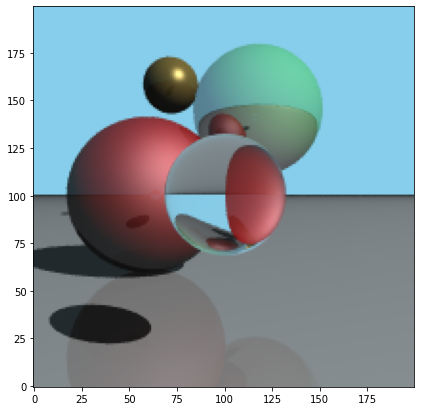

In [7]:
resolution = (200, 200)

entities = [
    # Lens
    create_sphere(np.array([ 0. , 0. ,  1.]), 0.1, white, np.array([1., 1., 1.]), white, 2, .0, 1.0, refindex_glass),
    # Red sphere
    create_sphere(np.array([-1. , 0. ,  4.]), 1. , white, np.array([1., 0., 0.]), white, 8, .2),
    # Green sphere
    create_sphere(np.array([ 0.5, 1.3,  5.]), 1. , white, np.array([0., 1., 0.]), white, 2, .6),
    # Gold sphere (ref: http://www.barradeau.com/nicoptere/dump/materials.html)
    create_sphere(np.array([-2. , 4. , 13.]), 1. ,
                  np.array([0.247250, 0.199500, 0.074500]),
                  np.array([0.751640, 0.606480, 0.226480]),
                  np.array([0.628281, 0.555802, 0.366065]), 51.2, .1),
    # Ground
    create_plane(np.array([0., -1.,    3.]), up, white, white, white, 1, 0.1)
]
scene = load_scene(entities)

render = np.zeros(resolution + (3,), dtype=np.float64)
%time process(render, scene, resolution, fov=90, aa=30)
render = render.clip(0, 1)

plt.figure(figsize=(7, 7))
plt.imshow(render, origin="lower")
plt.show()

In [8]:
from IPython.core.display import display, HTML
import skimage.io as skio
skio.imsave("render.png", np.uint8(255*render[::-1]))
display(HTML("<a href='render.png' target='_blank'>Download the render</a>"))